In [2]:
!pip install kagglehub

GET AND CHECK DATA

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("darshue/extracted-images")

print("Path to dataset files:", path)

100%|██████████| 3.40G/3.40G [02:47<00:00, 21.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/darshue/extracted-images/versions/19


If you're training the model using colab use the bottom  command to install the datasets. You'll need your kaggle api key which you can generate in your account settings at kaggle. Download the api key and paste the key when prompted to download the dataset

In [3]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/darshue/extracted-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abielkim
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/darshue/extracted-images


The code below checks if youre dataset has been installed at the correct path

1.   List item
2.   List item



In [4]:
import os
data_dir = './extracted-images/train/'

print("Path exists:", os.path.exists(data_dir))  # Should print True
print("Contents:", os.listdir(data_dir))  # Should list the 5 subclasses

Path exists: True
Contents: ['HGSC', 'CC', 'LGSC', 'MC', 'EC']


IMPORTS AND DEVICE

In [5]:
import torch
import os
import os.path
import numpy as np
import sys
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets

np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed_all(111)

In [6]:
if torch.cuda.is_available():
    print("CUDA available")
    device = torch.device("cuda")
else:
    print("CUDA not available")
    device = torch.device("cpu")
print("Device: ", device)

CUDA available
Device:  cuda


In [7]:
train_test_split = 0.8
batch_size = 32
num_epochs = 10
learning_rate = 0.001
num_classes = 5
num_workers = 4

# if youre not using colab, you can change the data_dir path below
# data_dir = '../data/train/

In [11]:
# mean, std = [0.7276], [0.1001]

mean=[0.8078, 0.6699, 0.8137]
std=[0.0925, 0.1143, 0.0710]

In [12]:
train_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((496, 496)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((496, 496)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [13]:

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=train_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=test_transform)

train_size = int(train_test_split * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print('Number of training samples:', len(train_loader.dataset))
print('Number of testing samples:', len(test_loader.dataset))

classes = [ 'CC', 'EC', 'HGSC', 'LGSC', 'MC' ]

Number of training samples: 20402
Number of testing samples: 5101


In [14]:
# Used to get mean and std of dataset, does not need to be run again
mean_transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize((496, 496)),
    transforms.ToTensor()
])
if False:
    dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=mean_transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=num_workers)

    # mean = 0.0
    # std = 0.0
    # nb_samples = 0

    # for images, _ in loader:
    #     batch_samples = images.size(0)
    #     # Flatten images in each batch: (batch_size, channels, height * width)
    #     images = images.view(batch_samples, images.size(1), -1)
    #     mean += images.mean(2).sum(0)
    #     std += images.std(2).sum(0)
    #     nb_samples += batch_samples

    # mean /= nb_samples
    # std /= nb_samples

    # print('Mean:', mean)
    # print('Std:', std)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, 3, -1)  # 3 channels
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    print('Mean:', mean)  # e.g., [0.485, 0.456, 0.406]
    print('Std:', std)   # e.g., [0.229, 0.224, 0.225]

In [18]:
from torchvision.models import resnet18

# oddly, I dont see where we defined output layer to have 5 classes?

model = resnet18(pretrained=True)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.fc = nn.Linear(model.fc.in_features, num_classes) # ???
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00025)

# Learning rate scheduler implementation
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= num_epochs)

Validation: 100%|██████████| 160/160 [00:18<00:00,  8.78it/s]


Epoch 1/10, Loss: 0.6586, Validation Accuracy: 0.7930, Test Accuracy: 0.7936
Saved new best model at epoch 1


Validation: 100%|██████████| 160/160 [00:18<00:00,  8.71it/s]


Epoch 2/10, Loss: 0.3788, Validation Accuracy: 0.8053, Test Accuracy: 0.8044
Saved new best model at epoch 2


Validation: 100%|██████████| 160/160 [00:18<00:00,  8.80it/s]


Epoch 3/10, Loss: 0.3064, Validation Accuracy: 0.5726, Test Accuracy: 0.5734


Validation: 100%|██████████| 160/160 [00:18<00:00,  8.75it/s]


Epoch 4/10, Loss: 0.2514, Validation Accuracy: 0.8845, Test Accuracy: 0.8824
Saved new best model at epoch 4


Validation: 100%|██████████| 160/160 [00:18<00:00,  8.77it/s]


Epoch 5/10, Loss: 0.2043, Validation Accuracy: 0.8696, Test Accuracy: 0.8724


Validation: 100%|██████████| 160/160 [00:18<00:00,  8.74it/s]


Epoch 6/10, Loss: 0.1622, Validation Accuracy: 0.9375, Test Accuracy: 0.9412
Saved new best model at epoch 6


Validation: 100%|██████████| 160/160 [00:18<00:00,  8.69it/s]


Epoch 7/10, Loss: 0.1158, Validation Accuracy: 0.9610, Test Accuracy: 0.9620
Saved new best model at epoch 7


Validation: 100%|██████████| 160/160 [00:17<00:00,  8.91it/s]


Epoch 8/10, Loss: 0.0751, Validation Accuracy: 0.9765, Test Accuracy: 0.9780
Saved new best model at epoch 8


Validation: 100%|██████████| 160/160 [00:17<00:00,  8.93it/s]


Epoch 9/10, Loss: 0.0495, Validation Accuracy: 0.9888, Test Accuracy: 0.9884
Saved new best model at epoch 9


Validation: 100%|██████████| 160/160 [00:18<00:00,  8.73it/s]


Epoch 10/10, Loss: 0.0348, Validation Accuracy: 0.9926, Test Accuracy: 0.9916
Saved new best model at epoch 10


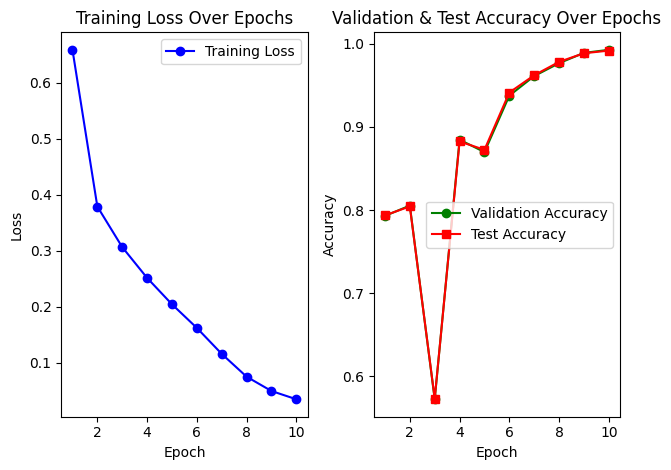

In [20]:
# Store values for plot
epoch_losses = []
val_accuracies = []
test_accuracies = []

# variables for saving our best model
best_val_accuracy = 0.0
best_epoch = 0
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
save_path = os.path.join(models_dir, 'best_model.pth')


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    #Training Loop
    loop = tqdm.tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    scheduler.step() #LR implementation after every epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss) # store data to plot

    #Validation Accuray
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_loop = tqdm.tqdm(test_loader, desc="Validation")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy) # store data to plot

    # Test Accuray
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct_test += (predictions == labels).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy) #store data to plot

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # save the best model based on validation acc.
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        torch.save(model.state_dict(), save_path)
        print(f"Saved new best model at epoch {epoch+1}")

plt.figure

#loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', linestyle='-', color='g', label="Validation Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', linestyle='-', color='r', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation & Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()